# Dữ liệu đã bỏ các mẫu chứa trường có giá trị NA

In [21]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Dưới đây là các hàm phục vụ việc tiền xử lý dữ liệu như one-hot coding hoặc chia tập train - validation

In [22]:
# Function to one-hot coding using get_dummies() method
def one_hot(matrix, column):
    type_dummies = pd.get_dummies(matrix[column], prefix='type')
    matrix.drop([column], axis=1, inplace=True)
    matrix = pd.concat([matrix, type_dummies], axis=1)
    return matrix


# Function to split the training set and validation set
def split_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=test_size,
                                                        random_state=42)
    return x_train, x_test, y_train, y_test

In [23]:
# Read data
# Change data path on your computer
data_path = 'earthquakes.csv'
data = pd.read_csv(data_path)
# Print the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1137 non-null   object 
 1   magnitude        1137 non-null   float64
 2   type             1137 non-null   object 
 3   title            1137 non-null   object 
 4   date             1137 non-null   object 
 5   time             1137 non-null   int64  
 6   updated          1137 non-null   int64  
 7   url              1137 non-null   object 
 8   detailUrl        1137 non-null   object 
 9   felt             1137 non-null   int64  
 10  cdi              1137 non-null   int64  
 11  mmi              1137 non-null   int64  
 12  alert            764 non-null    object 
 13  status           1137 non-null   object 
 14  tsunami          1137 non-null   int64  
 15  sig              1137 non-null   int64  
 16  net              1137 non-null   object 
 17  code          

In [24]:
# Print the data description
data.describe()

,magnitude,time,updated,felt,cdi,mmi,tsunami,sig,nst,dmin,rms,gap,depth,latitude,longitude,distanceKM,postcode,timezone
count,1137.000000,1.137000e+03,1.137000e+03,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,197.000000,1137.000000
mean,4.856675,1.712109e+12,1.716593e+12,414.408091,2.925242,4.320141,0.059807,432.698329,115.094107,1.342604,0.585974,55.055286,41.287300,27.308909,-3.930635,52.289358,83086.131980,21.741425
std,1.047840,1.143033e+10,9.671955e+09,5746.971362,2.562707,1.453949,0.237232,256.177844,91.877870,1.704364,0.308556,37.609237,87.866489,20.133139,118.043697,56.027469,12812.555204,440.864430
min,3.000000,1.687542e+12,1.693083e+12,0.000000,0.000000,1.000000,0.000000,138.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-43.706400,-179.807000,0.000000,8833.000000,-720.000000
25%,3.800000,1.701663e+12,1.707609e+12,0.000000,0.000000,4.000000,0.000000,234.000000,37.000000,0.100000,0.300000,30.000000,7.550000,24.195400,-104.452000,15.000000,79331.000000,-360.000000
50%,5.300000,1.713810e+12,1.719958e+12,2.000000,3.000000,4.000000,0.000000,449.000000,102.000000,0.680000,0.630000,49.000000,10.000000,31.667700,-68.682000,37.000000,79772.000000,-180.000000
75%,5.600000,1.722885e+12,1.725384e+12,24.000000,5.000000,5.000000,0.000000,518.000000,157.000000,2.061000,0.780000,68.000000,34.723000,37.497600,126.628000,61.000000,92530.000000,480.000000
max,7.600000,1.726661e+12,1.726672e+12,183786.000000,9.000000,9.000000,1.000000,2419.000000,619.000000,12.457000,2.520000,256.000000,639.503000,68.176100,179.972000,298.000000,99827.000000,780.000000


## Tiền xử lý dữ liệu

In [25]:
# Remove some features that aren't important for classify / clustering the alert of the earthquake
# Feature 'date' is already converted to float type in the original dataset 
data.drop(['id', 'date', 'title', 'url', 'detailUrl',
           'ids', 'sources', 'types', 'net', 'code',
           'geometryType', 'status', 'postcode', 'what3words',
           'locationDetails'], axis=1, inplace=True)
# Replace Null value of column 'alert' to unknown 
data.fillna({'alert': 'unknown'}, inplace=True)
# Remove samples contain Null values
data.dropna(how='any', axis=0, inplace=True)

# Columns will be one-hot coding
string_columns = data.select_dtypes(include=['object']).columns.tolist()
string_columns.remove('alert')

for column in string_columns:
    data = one_hot(data, column)
    
x_data = data.drop(['alert'], axis=1)
x_data = StandardScaler().fit_transform(x_data)
y_data = data['alert']

## Giảm chiều dữ liệu
### Phương pháp PCA

In [26]:
# Dimensionality reduction
# Using PCA method
pca = PCA(n_components=2, random_state=42)
x_data_pca = pca.fit_transform(x_data)

**Trực quan hóa dữ liệu**

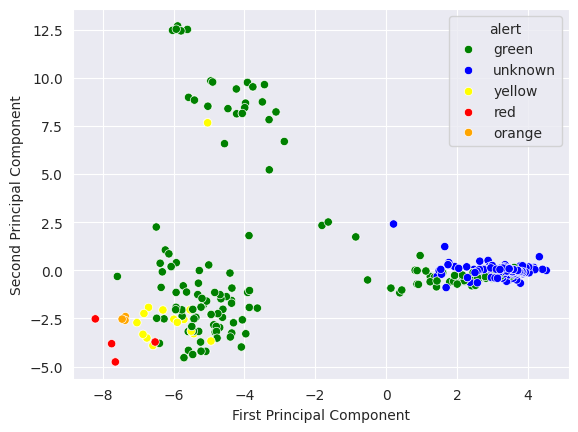

In [27]:
# Data visualization (2d scatter plot) 
pc1 = x_data_pca[:, 0]
pc2 = x_data_pca[:, 1]
# Creat scatter plot
custom_palette = {'red': "red", 'yellow': "yellow", 'green': "green", 'unknown': "blue", 'orange': "orange"}
plot = sns.scatterplot(x=pc1, y=pc2, hue=y_data, palette=custom_palette)
# Rename axis
plot.set(xlabel="First Principal Component", ylabel="Second Principal Component")
plt.show()

**Đánh giá các thành phần chính theo tham số thống kê** và **Xác định lượng thông tin được bảo tồn theo phương sai giải thích**

In [28]:
# Print the explained variance after reduce dimension of the data 
print(f'Explained variance: {np.cumsum(pca.explained_variance_ratio_)}')
# Print the statistic values of Principal Component
pd.DataFrame(data=x_data_pca,
             columns=['First Principal Component',
                      'Second Principal Component']).describe()

Explained variance: [0.01499077 0.02386945]


,First Principal Component,Second Principal Component
count,6.640000e+02,6.640000e+02
mean,4.280378e-17,2.140189e-17
std,4.131612e+00,3.179668e+00
min,-8.207969e+00,-4.756557e+00
25%,-4.822971e+00,-9.240485e-01
50%,2.500152e+00,-1.731444e-01
75%,3.497358e+00,1.182530e-02
max,4.522021e+00,1.269162e+01


**Thực hiện hiển thị trực quan đối với dữ liệu theo từng cặp 02 thành phần chính**

<Figure size 2000x2000 with 0 Axes>

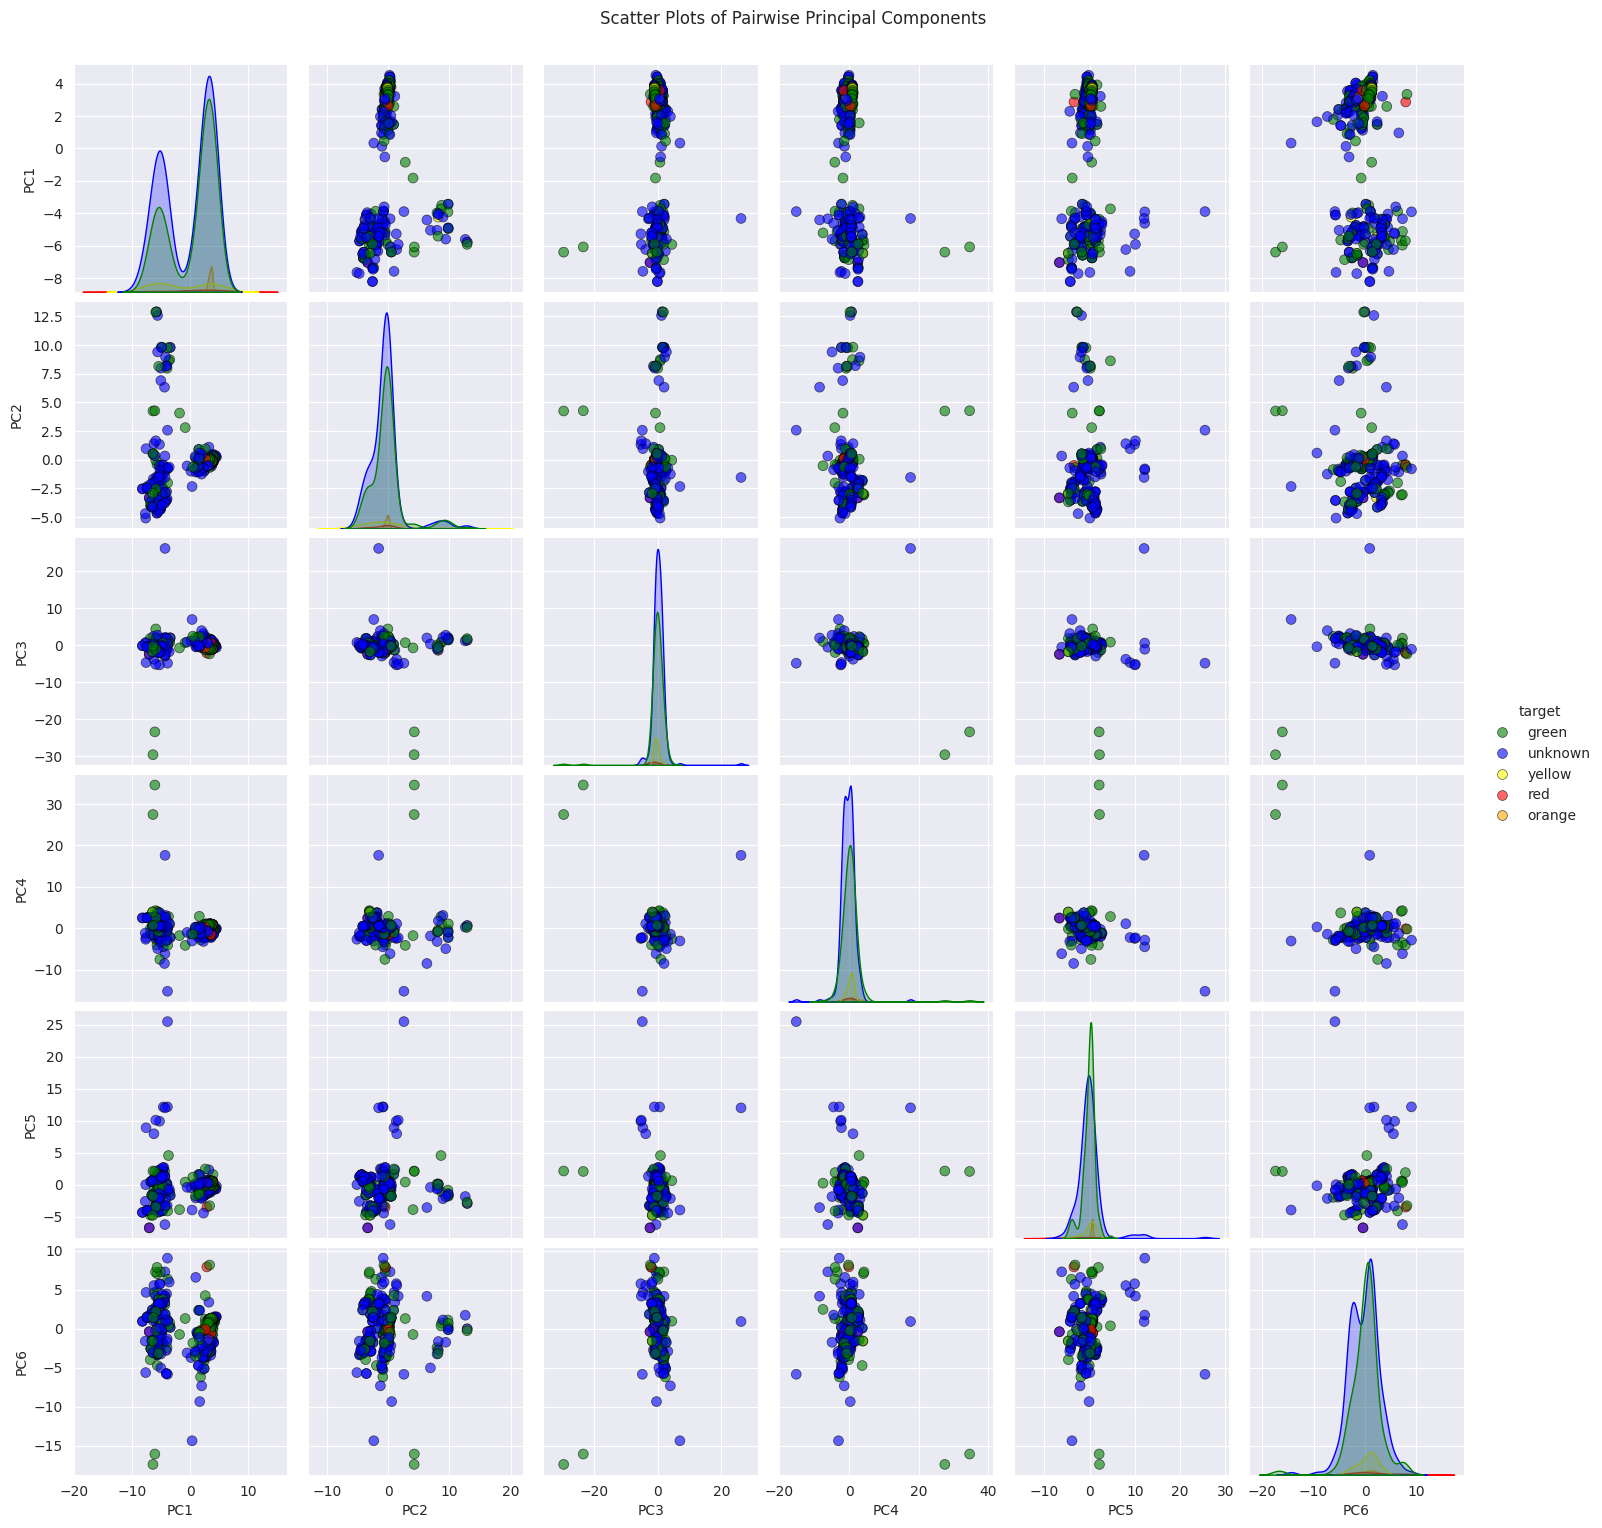

In [29]:
pca_pair = PCA(n_components=6)
X_pca = pca_pair.fit_transform(x_data)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i + 1}' for i in range(6)])
df_pca['target'] = y_data
plt.figure(figsize=(20, 20))
custom_palette = {'red': "red", 'yellow': "yellow", 'green': "green", 'unknown': "blue", 'orange': "orange"}
sns.pairplot(df_pca, hue='target', diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'k'},
             vars=[f'PC{i + 1}' for i in range(6)], palette=custom_palette)  # Sử dụng 6 thành phần chính
plt.suptitle("Scatter Plots of Pairwise Principal Components", y=1.02)
plt.show()

### Phương pháp LDA

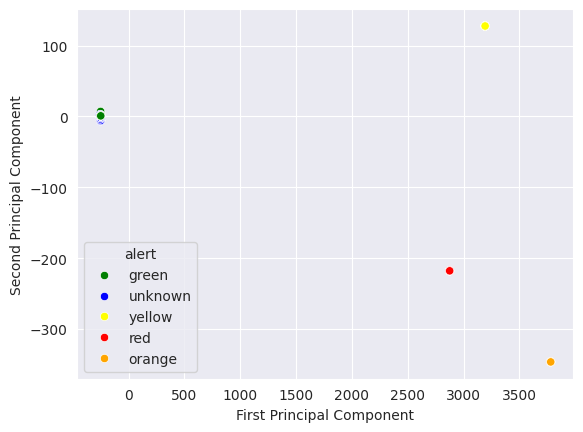

In [30]:
lda = LDA(n_components=2)
x_data_lda = lda.fit_transform(x_data, y_data)
# Data visualization (2d scatter plot) 
pc1 = x_data_lda[:, 0]
pc2 = x_data_lda[:, 1]
# Creat scatter plot
custom_palette = {'red': "red", 'yellow': "yellow", 'green': "green", 'unknown': "blue", 'orange': "orange"}
plot_lda = sns.scatterplot(x=pc1, y=pc2, hue=y_data, palette=custom_palette)
# Rename axis
plot_lda.set(xlabel="First Principal Component", ylabel="Second Principal Component")
plt.show()